# Simple linear regression

## Intro

### The SLE model

Suppose we have a simple labelled dataset with one feature $X$ and one target $Y$. Assume that both are continuous variables, and we have $m$ samples. According to our convention, we denote the $i$-th sample as $(x_i, y_i)$, where $x_i$ is the feature and $y_i$ is the target.

In **simple linear regression**, we assume that the relationship between $X$ and $Y$ is linear. That is, we assume that there exists a pair $\mathbf{w} = (b,w) \in \mathbb{R}^2$ (the parameters of the model) such that
\begin{align*}
    y_i & = F_{\mathbf{w}}(x_i) + \epsilon_i \\
    & = b + wx_i + \epsilon_i,
\end{align*}
where each $\epsilon_i$ is a small error term. (Later, we will be more precise on what exactly we mean by "small error term", but for now let's proceed with a vague idea.)

### Formula for MSE loss
The standard loss function for linear regression is the **mean squared error** (MSE). Recall that, if we denote each prediction as $\hat{y}_i = F_{\mathbf{w}}(x_i)$, then the MSE loss function is defined as
\begin{equation*}
    J(m,b) = \frac{1}{m} \sum_{i=1}^m \epsilon_i^2 = \frac{1}{m} \sum_{i=1}^m (y_i - (b + wx_i))^2. \tag{1}
\end{equation*}
Sometimes, we may also write it as $J(\mathbf{w})$.

### Fitting the model
This requires us to solve the following optimization problem: *Find the parameters $\hat{\mathbf{w}} = (\hat{b},\hat{w})$ which minimize $J(b,w)$, i.e. which satisfy*:
\begin{align*}
    \hat{\mathbf{w}} & = \argmin_{\mathbf{w} \in \mathbb{R}^2} \; J(\mathbf{w})
\end{align*}
The graph of the fitted function $F_{\hat{\mathbf{w}}}$ is called the **regression line** or **line of best fit**. It turns out that the parameters $\hat{\mathbf{w}} = (\hat{b},\hat{w})$ can be computed in closed form by solving a system of two linear equations in the unknowns $b$ and $w$; these are called the **normal equations**. In this notebook, we will derive the normal equations using two different methods: calculus and linear algebra.

### Generating a synthetic dataset
In this notebook, we will derive the formulas for $\hat{\mathbf{w}}$ in two ways, first using calculus, and then using linear algebra. Before any of that, however, we first generate a synthetic dataset of points to work with. That is, we construct a set of points on a line and then add in some noise. This will be convenient because we will know the "true" linear relationship in our data, and we can compare it with the line of best fit that we will derive.

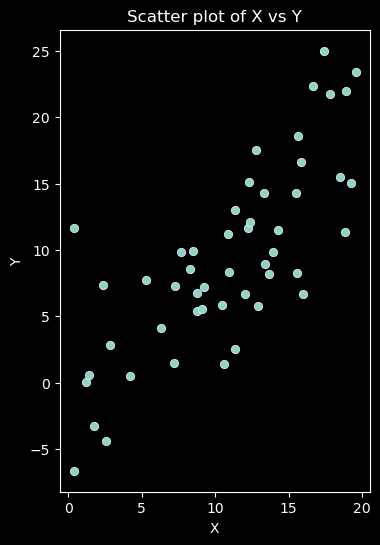

,X,Y
0,0.375796,-6.630714
1,0.404368,11.677371
2,1.204509,0.015347
3,1.420721,0.546205
4,1.742586,-3.269908


In [1]:
# Generate 50 random x values between 0 and 20. Generate corresponding y values using the function y = 2x + 1. Add some noise to the y values.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set the random seed for reproducibility
np.random.seed(0)
# Generate random x values and sort in ascending order
x = np.random.uniform(0, 20, 50)
x.sort()
# Generate residuals
residuals = np.random.normal(0, 5, 50)
# Generate y values using the function y = 0.8x + 1.6 and add noise
y = 0.8* x + 1.6 + residuals
# Create a DataFrame
df = pd.DataFrame({'X': x, 'Y': y})

# Plot the data using seaborn
plt.figure(figsize=(4, 6))
sns.scatterplot(data=df, x='X', y='Y')
#add labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of X vs Y')
plt.show()

df.head()

## Derivation of normal equations via calculus

### Visualizing residuals

Below, we add a nice animation illustrating how residuals, and the corresponding MSE, change as we move the regression line. The animation is created using the `manim` library made by the creator of 3Blue1Brown (the greatest math-video channel to have existed). If you want to run it, you can install it with `conda install manim`. 

In [17]:
from manim import *
config.verbosity = "ERROR"
class RegressionWithResiduals(Scene):
    def construct(self):
        # Create axes with original parameters.
        axes = Axes(
            x_range=[0, 20, 5],
            y_range=[-5, 30, 5],
            x_length=10,
            y_length=6,
            axis_config={"include_numbers": True, "font_size": 30},
        )
        axes.scale(0.9)
        x_label = axes.get_x_axis_label("X")
        y_label = axes.get_y_axis_label("Y")
        self.play(Create(axes), Write(x_label), Write(y_label), run_time=2)
        self.wait(1)
                
        # Save the data as a list of tuples for easy processing.
        data = list(zip(df['X'], df['Y']))
        
        # Create scatter points.
        scatter_points = VGroup(*[
            Dot(point=axes.c2p(x, y), color=YELLOW) for x, y in data
        ])
        self.play(FadeIn(scatter_points), run_time=2)
        self.wait(1)
        
        # Define ValueTrackers for the regression line parameters.
        m_tracker = ValueTracker(0.5)
        b_tracker = ValueTracker(1)
        
        # Always redraw the regression line using the current m and b.
        regression_line = always_redraw(lambda: axes.plot(
            lambda x: m_tracker.get_value() * x + b_tracker.get_value(),
            x_range=[0, 20],
            color=BLUE
        ))
        self.play(Create(regression_line), run_time=2)
        self.wait(1)

        # Fixed label for the line equation below the x-axis. It updates automatically.
        eq_label = always_redraw(lambda: MathTex(
            "y =",
            f"{m_tracker.get_value():.1f}x",
            "+",
            f"{b_tracker.get_value():.1f}"
        ).next_to(axes, UP))
        
        self.play(Write(eq_label), run_time=1)
        self.wait(2)
        
        # Draw vertical residual lines from each data point to the regression line.
        residuals = always_redraw(lambda: VGroup(*[
            Line(
                start=axes.c2p(x, y),
                end=axes.c2p(x, m_tracker.get_value() * x + b_tracker.get_value()),
                color=RED
            )
            for x, y in data
        ]))
        self.play(Create(residuals), run_time=2)
        self.wait(1)
        
        # Define an always_redraw updater for the MSE.
        mse_tracker = always_redraw(lambda: MathTex(
            "\\text{MSE} = " + f"{np.mean([(y - (m_tracker.get_value()*x + b_tracker.get_value()))**2 for x, y in data]):.2f}"
        ).to_corner(DR, buff=0.5))
        self.play(Write(mse_tracker), run_time=1)
        self.wait(2)
        
        # Animate changes to the regression line parameters.
        # As the line moves, both the residuals and the MSE update.

        self.play(
            m_tracker.animate.set_value(0.5),
            b_tracker.animate.set_value(-2),
            run_time=1
        )
        self.wait(1)
        self.play(
            m_tracker.animate.set_value(0.5),
            b_tracker.animate.set_value(3),
            run_time=1
        )
        self.wait(1)
        self.play(
            m_tracker.animate.set_value(0.5),
            b_tracker.animate.set_value(2),
            run_time=1
        )
        self.wait(2)

        self.play(
            m_tracker.animate.set_value(-0.5),
            b_tracker.animate.set_value(3),
            run_time=1
        )
        self.wait(1)
        self.play(
            m_tracker.animate.set_value(2),
            b_tracker.animate.set_value(0),
            run_time=1
        )
        self.wait(1)
        self.play(
            m_tracker.animate.set_value(1),
            b_tracker.animate.set_value(2),
            run_time=1
        )
        self.wait(1)
        self.play(
            m_tracker.animate.set_value(0.8),
            b_tracker.animate.set_value(1.6),
            run_time=1
        )
        self.wait(2)

%manim -ql RegressionWithResiduals

Manim Community v0.19.0

### Directional derivatives

The MSE loss function is a function of two variables, $m$ and $b$, so we can visualize it's graph as a surface in 3D space. The gradient of our loss function, 
\begin{equation*}
    \nabla J(b,w) = \begin{bmatrix} \; \frac{\partial J}{\partial b} & \frac{\partial J}{\partial w} \; \end{bmatrix},
\end{equation*}
is a vector in the $(b,w)$-plane which captures the instantaneous rate of change of $J$ at any given point. But what exactly does this mean? 

Well, if we choose a particular point $\mathbf{w}_0 = (b_0,w_0) \in \mathbb{R}^2$, then we can move in any direction on the plane. The direction is represented uniquely by a unit vector $\mathbf{u} \in \mathbb{R}^2$. Then, the rate of change of $J$ in the direction of $\mathbf{u}$ (also knows as the **directional derivative** of $J$ with respect to $\mathbf{u}$ at $\mathbf{w}_0$) is given by the dot product
\begin{align*}
    \nabla_{\mathbf{u}} J(\mathbf{w}_0) & \coloneqq \nabla J(\mathbf{w}_0) \cdot \mathbf{u} \\
                                        & = \begin{bmatrix} \; \frac{\partial J}{\partial b} & \frac{\partial J}{\partial w} \; \end{bmatrix} \cdot \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} \\
                                        & = \frac{\partial J}{\partial b} u_1 + \frac{\partial J}{\partial w} u_2.
\end{align*}
The notation above might be a little confusing; $\nabla_{\mathbf{u}} J(\mathbf{w})$ should be thought of as a new function from $\mathbb{R}^2$ to $\mathbb{R}$, which takes in a point $\mathbf{w} = \mathbf{w}_0$ and outputs the directional derivative along $\mathbf{u}$ at that point.
The interpretation of the directional derivative is then very similar to the interpretation of the classical one-variable derivative: if we move from $\mathbf{w}_0$ to $\mathbf{w}_0 + \epsilon \mathbf{u}$, then the change in $J$ is approximately equal to the directional derivative $\epsilon \nabla_{\mathbf{u}} J(\mathbf{w}_0)$. Thus, the dot product is used to incorporate the direction of movement into the rate of change!

### Gradients and minima
Suppose we are at some point $\mathbf{w}_0 \in \mathbb{R}^2$. Observe that as we vary our direction of movement $\mathbf{u}$, the directional derivative $\nabla J(\mathbf{w}_0) \cdot \mathbf{u}$ can be positive, negative, or zero. In particular, we have
\begin{equation*}
    - || \nabla J(\mathbf{w}_0)|| \leq \nabla_{\mathbf{u}} J(\mathbf{w}_0) \leq ||\nabla J(\mathbf{w}_0)||.
\end{equation*}
This follows from the fact that the dot product of two vectors is the product of their magnitudes, times the cosine of the angle between them. Thus:

- If the angle between $\nabla J(\mathbf{w}_0)$ and $\mathbf{u}$ is acute, then the directional derivative is positive. It is maximized when $\mathbf{u}$ is in the same direction as $\nabla J(\mathbf{w}_0)$. In particular **the gradient $\nabla J(\mathbf{w}_0)$ points in the direction of steepest ascent of $J$ at $\mathbf{w}_0$**. That is, it tells us the most *efficient way* to adjust the parameters $(b_0,w_0)$ so as to increase the loss $J$.
- If the angle between $\nabla J(\mathbf{w}_0)$ and $\mathbf{u}$ is obtuse, then the directional derivative is negative. It is minimized when $\mathbf{u}$ is in the opposite direction as $\nabla J(\mathbf{w}_0)$. In particular **the gradient $\nabla J(\mathbf{w}_0)$ points in the direction of steepest descent of $J$ at $\mathbf{w}_0$**. That is, it tells us the most *efficient way* to adjust the parameters $(b_0,w_0)$ so as to decrease the loss $J$. This is what we ultimately will use to train complicated models.

As a consequence of the above facts, we can cook up a "pure thought" argument for why the gradient needs to be the zero vector at any local minimum or maximum of $J$. It goes as follows. Suppose $J$ attains a local minimum at the point $\mathbf{w}_0$. Then, for *any* direction $\mathbf{u}$, the directional derivative $\nabla_{\mathbf{u}} J(\mathbf{w}_0)$ must be non-negative. Taking the reverse direction $-\mathbf{u}$, we see that the directional derivative $\nabla_{-\mathbf{u}} J(\mathbf{w}_0) = - \nabla_{\mathbf{u}} J(\mathbf{w}_0)$ must also be non-negative. Thus, we have 
\begin{equation*}
    \nabla_{\mathbf{u}} J(\mathbf{w}_0) = \nabla J(\mathbf{w}_0) \cdot \mathbf{u} = 0, \quad \textup{ for all } \mathbf{u} \in \mathbb{R}^2.
\end{equation*}
The only vector whose dot product with every other vector is zero is the zero vector itself. Thus, we conclude that at any local minimum $\mathbf{w}_0$, the gradient $\nabla J(\mathbf{w}_0) = \mathbf{0} \in \mathbb{R}^2$!

### Product rules for dot products
Now, we are ready to find the minimum of the loss function $J(m,b)$. We will do this by setting the gradient $\nabla J(m,b)$ to zero. This will yield a system of two linear equations in $m$ and $b$, and we will solve this to extract the desired values $\hat{m}$ and $\hat{b}$. It will be helpful to use some facts about partial derivatives of vectors and dot products.

Suppose we have a vector-valued function $\mathbf{f}: \mathbb{R} \to \mathbb{R}^m$, defined by $\mathbf{f}(w) = \begin{bmatrix}\;f_1(w) \dotsb f_m(w) \;\end{bmatrix}^T$. Then, the **derivative of $\mathbf{f}$ with respect to $w$** is defined to be the vector-valued function $d\mathbf{f}/dw : \mathbb{R} \to \mathbb{R}^m$ given by
\begin{equation*}
    \frac{d\mathbf{f}}{dw} = \begin{bmatrix} \; \frac{df_1}{dw} \dotsb \frac{df_m}{dw} \; \end{bmatrix}^T.
\end{equation*}
(NOTE: we implicitly assume here that all these derivatives exist, in which case we say that "$\mathbf{f}$ is differentiable".)
Given two such functions $\mathbf{f},\mathbf{g}: \mathbb{R} \to \mathbb{R}^m$, the **dot product of $\mathbf{f}$ and $\mathbf{g}$** is the scalar function $\mathbf{f} \cdot \mathbf{g} : \mathbb{R} \to \mathbb{R}$ given by
\begin{equation*}
    (\mathbf{f} \cdot \mathbf{g})(w) = f_1g_1(w) + \dotsb + f_mg_m(w).
\end{equation*}
Then, we have the following: 

**Product rule for dot products I.** Let $\mathbf{f},\mathbf{g}: \mathbb{R} \to \mathbb{R}^m$ be two differentiable vector-valued functions. Then, the derivative of the dot product $\mathbf{f} \cdot \mathbf{g}$ is given by
\begin{equation*}
    \frac{d}{dw} (\mathbf{f} \cdot \mathbf{g}) = \mathbf{g} \cdot \frac{d\mathbf{f}}{dw} + \mathbf{f} \cdot \frac{d\mathbf{g}}{dw}.
\end{equation*}
In particular:

- We have $$\frac{d ||\mathbf{f}||^2}{dw} = 2 \mathbf{f} \cdot \frac{d\mathbf{f}}{dw}.$$
- If $\mathbf{g}$ is a constant vector, then $$\frac{d(\mathbf{f} \cdot \mathbf{g})}{dw} = \mathbf{g} \cdot \frac{d\mathbf{f}}{dw}. $$

Similarly, for a vector-valued function $\mathbf{f}:\mathbb{R}^k \to \mathbb{R}^m$ defined by $f(\mathbf{w}) = \begin{bmatrix} \; f_1(\mathbf{w}) \dotsb f_m(\mathbf{w}) \; \end{bmatrix}^T$ (where $\mathbf{w} = (w_1,\dotsc,w_n)$), the **partial derivative of $\mathbf{f}$ with respect to $w_j$** is defined to be the vector-valued function $\partial \mathbf{f}/ \partial w_j : \mathbb{R} \to \mathbb{R}^m$ given by
\begin{equation*}
    \frac{\partial \mathbf{f}}{\partial w_j} = \begin{bmatrix} \; \frac{\partial f_1}{\partial w_j} \dotsb \frac{\partial f_m}{\partial w_j} \; \end{bmatrix}^T.
\end{equation*}
Taking the dot product of these functions yields a scalar function $\mathbf{f} \cdot \mathbf{g} : \mathbb{R}^k \to \mathbb{R}$. Again, we have a similar 

**Product rule for dot products II.** 
Let $\mathbf{f},\mathbf{g}: \mathbb{R}^k \to \mathbb{R}^m$ be two differentiable vector-valued functions. Then, the partial derivative of the dot product $\mathbf{f} \cdot \mathbf{g}$ with respect to $w_j$ (where $\mathbf{w} = (w_1,\dotsc,w_k)$) is given by
\begin{equation*}
    \frac{\partial}{\partial w_j} (\mathbf{f} \cdot \mathbf{g}) = \mathbf{g} \cdot \frac{\partial \mathbf{f}}{\partial w_j}  + \mathbf{f} \cdot \frac{\partial \mathbf{g}}{\partial w_j}.
\end{equation*}
In particular:

- We have $$\frac{\partial}{\partial w_j} ||\mathbf{f}||^2 = 2 \mathbf{f} \cdot \frac{\partial \mathbf{f}}{\partial w_j}.$$
- If $\mathbf{g}$ is a constant vector, then $$\frac{\partial}{\partial w_j} (\mathbf{f} \cdot \mathbf{g}) = \mathbf{g} \cdot \frac{\partial \mathbf{f}}{\partial w_j}. $$

### Derivation of normal equations

We will now compute the gradient of $J(b,w)$, and set it to zero. As usual, we assume our dataset has $m$ rows, so our gradient is a function $J:\mathbb{R}^2 \to \mathbb{R}$. The vector of predicted values $\hat{y} \in \mathbb{R}^m$ can be viewed as a vector-valued function $\hat{y}:\mathbb{R}^2 \to \mathbb{R}^m$, and similarly, so can the vector of residuals $\epsilon = \mathbf{y} - \hat{\mathbf{y}}$. Recall that our loss is defined by
\begin{equation*}
    J(\mathbf{w}) = \frac{1}{m} ||\mathbf{y} - \hat{\mathbf{y}}||^2.
\end{equation*}
Using the product rule for dot products, taking the partial with respect to $b$ gives
\begin{align*}
    \frac{\partial J}{\partial b} & = \frac{1}{m} \frac{\partial ||\mathbf{y} - \hat{\mathbf{y}}||^2}{\partial b} \\
                                & = \frac{2}{m} (\mathbf{y} - \hat{\mathbf{y}}) \cdot \frac{\partial (\mathbf{y} - \hat{\mathbf{y}})}{\partial b} \\
                                & = \frac{2}{m} (\mathbf{y} - \hat{\mathbf{y}}) \cdot (-\frac{\partial \hat{\mathbf{y}}}{\partial b}) \\
\end{align*}
A similar computation shows that
\begin{align*}
    \frac{\partial J}{\partial w} & = \frac{1}{m} \frac{\partial ||\mathbf{y} - \hat{\mathbf{y}}||^2}{\partial w} \\
                                & = \frac{2}{m} (\mathbf{y} - \hat{\mathbf{y}}) \cdot (-\frac{\partial \hat{\mathbf{y}}}{\partial w}) 
\end{align*}
Expanding out the dot product on the right-hand sides, we see that
\begin{equation}\tag{1}
    \begin{alignedat}{2}
        \frac{\partial J}{\partial b} & = 0 \iff \hat{\mathbf{y}} \cdot \frac{\partial \hat{\mathbf{y}}}{\partial b}  && = \mathbf{y} \cdot \frac{\partial {\mathbf{y}}}{\partial b} \\
        \frac{\partial J}{\partial w} & = 0 \iff \hat{\mathbf{y}} \cdot \frac{\partial \hat{\mathbf{y}}}{\partial w}  && = \mathbf{y} \cdot \frac{\partial \hat{\mathbf{y}}}{\partial w}
    \end{alignedat}
\end{equation}
To break this down further, let's compute the partials of $\hat{\mathbf{y}}$ with respect to $b$ and $w$. Recall that $\hat{\mathbf{y}} = b \mathbf{1} + m \mathbf{x}$, where $\mathbf{1} \in \mathbb{R}^m$ is the vector of all ones and $\mathbf{x} \in \mathbb{R}^m$ is the column vector of features. So, we have
\begin{equation}\tag{2}
    \begin{alignedat}{2}
        \frac{\partial \hat{\mathbf{y}}}{\partial b} & = \frac{\partial}{\partial b} (b\mathbf{1} + w\mathbf{x})  && = \mathbf{1} \in \mathbb{R}^m \\
        \frac{\partial \hat{\mathbf{y}}}{\partial w} & = \frac{\partial}{\partial w} (b\mathbf{1} + w\mathbf{x})  && = \mathbf{x} \in \mathbb{R}^m
    \end{alignedat}
\end{equation}
Combining (1) and (2) above, we see that 
\begin{align*}
        \frac{\partial J}{\partial b} = 0 & \iff (b \mathbf{1} + m \mathbf{x}) \cdot \mathbf{1} = \mathbf{y} \cdot \mathbf{1} \\
                                        &  \iff b (\mathbf{1}\cdot \mathbf{1}) + w (\mathbf{x} \cdot \mathbf{1}) = \mathbf{y} \cdot \mathbf{1}
\end{align*}
By the same token, we have
\begin{align*}
        \frac{\partial J}{\partial w} = 0 & \iff (b \mathbf{1} + m \mathbf{x}) \cdot \mathbf{x} = \mathbf{y} \cdot \mathbf{x} \\
                                        &  \iff b (\mathbf{1}\cdot \mathbf{x}) + w (\mathbf{x} \cdot \mathbf{x}) = \mathbf{y} \cdot \mathbf{x}
\end{align*}
Thus, our two linear equations in $b$ and $w$ are given by
\begin{equation*}
    \begin{alignedat}{2}
        b (\mathbf{1}\cdot \mathbf{1}) + w (\mathbf{x} \cdot \mathbf{1}) & = \mathbf{y} \cdot \mathbf{1} \\
        b (\mathbf{1}\cdot \mathbf{x}) + w (\mathbf{x} \cdot \mathbf{x}) & = \mathbf{y} \cdot \mathbf{x},
    \end{alignedat}
\end{equation*}
which we can rewrite as the matrix equation
\begin{equation}\tag{3}
    \begin{bmatrix}
        \mathbf{1}\cdot \mathbf{1} & \mathbf{x} \cdot \mathbf{1} \\
        \mathbf{1}\cdot \mathbf{x} & \mathbf{x} \cdot \mathbf{x}
    \end{bmatrix}
    \begin{bmatrix}
        b \\ w
    \end{bmatrix}
    =
    \begin{bmatrix}
        \mathbf{y} \cdot \mathbf{1} \\ \mathbf{y} \cdot \mathbf{x}
    \end{bmatrix}.
\end{equation}
The above linear system is what we referred to as the normal equations. Our desired optimal parameters $(\hat{b},\hat{w})$ (which make the gradient zero) are the solution to the linear system (3) above! To solve this, all we need to do now is multiply both sides with the inverse of the matrix on the left. I will simply write down the final solution below, but the computation is left to you in HW 1. Before writing out the solution, however, let's see how to re-derive the same matrix equation using linear algebra.

## Derivation of normal equations via linear algebra

### Parallel and perpendicular components
Recall that if we have two vectors $\mathbf{y}$ and $\mathbf{u}$ in some space $\mathbf{R}^m$, then we can decompose $\mathbf{y}$ into a sum of two components: one parallel to $\mathbf{u}$, and one perpendicular to $\mathbf{u}$. The parallel component is denoted $P_{\mathbf{u}}\mathbf{v}$, and the perpendicular component is simply $\mathbf{v} - P_{\mathbf{u}}\mathbf{v}$. 

Since $P_{\mathbf{u}} \mathbf{v}$ is parallel to $\mathbf{u}$, we can write it as $c \mathbf{u}$ for some scalar $c$. To find $k$, we use the fact that $c \mathbf{u}$ is orthogonal to the perpendicular component $\mathbf{v} -  c{\mathbf{u}}$. Thus, we can determine the value of $c$ by solving the equation
\begin{equation*}
    \mathbf{u} \cdot (\mathbf{v} - c{\mathbf{u}}) = 0.
\end{equation*}
As you will show in HW 1, solving this equation yields 
\begin{equation*}
    c = \frac{\mathbf{u} \cdot \mathbf{v}}{\mathbf{u} \cdot \mathbf{u}}.
\end{equation*}
Thus, the full decomposition into parallel and perpendicular components is given by
\begin{equation*}
    \mathbf{v} = \underbrace{\frac{\mathbf{u} \cdot \mathbf{v}}{\mathbb{u} \cdot \mathbf{u}} \mathbf{u}}_{\textup{parallel}} + \underbrace{\left(\mathbf{v} - \frac{\mathbf{u} \cdot \mathbf{v}}{\mathbf{u} \cdot \mathbf{u}} \mathbf{u}\right)}_{\textup{perpendicular}}.
\end{equation*}

### Subspaces of $\mathbb{R}^m$
Given vectors $\mathbf{v}_1,\dotsc,\mathbf{v}_n,\mathbf{y} \in \mathbb{R}^m$, we say that $\mathbf{y}$ is a *linear combination$ of the $\mathbf{v}_i$'s if there exist scalars $c_1,\dotsc,c_n \in \mathbb{R}$  such that
\begin{equation*}
    \mathbf{y} = c_1\mathbf{v}_1 + \dotsb + c_n \mathbf{v}_n \in \mathbb{R}^m.
\end{equation*}

The **span** of the vectors $\mathbf{v}_1,\dotsc,\mathbf{v}_n$ is the set of all linear combinations:
\begin{equation*}
    \textup{span}(\mathbf{v}_1,\dotsc,\mathbf{v}_n) = \{c_1\mathbf{v}_1 + \dotsb + c_n \mathbf{v}_n \in \mathbb{R}^m \mid c_1,\dotsc,c_n \in \mathbb{R} \}.
\end{equation*}
Note that the set $U = \textup{span}(\mathbf{v}_1,\dotsc,\mathbf{v}_n)$ is a subset of $\mathbb{R}^m$. In fact (as you will show in HW 1), $U$ is a **subspace** of $\mathbb{R}^m$, which means that if $\mathbf{u}_1,\dotsc,\mathbf{u}_r$ are vectors in $U$, then any linear combination of these vectors is also in $U$ (another way to say this is that *$U$ is closed under linear combinations*). In particular, being a subspace means that $U$ contains the zero vector $\mathbf{0} \in \mathbb{R}^m$.

**Example.** Spans are quite intuitive to visualize.

- The span of a single (non-zero) vector $\mathbf{v} \in \mathbb{R}^m$ is the set of all scalar multiples of $\mathbf{v}$; if you think about it, this is the line through the origin in $\mathbb{R}^m$ that contains $\mathbf{v}$. 
- Suppose we have two non-zero vectors $\mathbf{v}_1,\mathbf{v}_2 \in \mathbb{R}^m$. Each of these vectors spans a line through the origin. There are two cases to consider, to understand $\textup{span}(\mathbf{v}_1,\mathbf{v}_2)$:
    - If $\mathbf{v}_2 = \lambda \mathbf{v}_1$ for some scalar $\lambda \in \mathbb{R}$, then the two lines are the same, and $\textup{span}(\mathbf{v}_1,\mathbf{v}_2)$ is the same line. To see this algebraically, note that any linear combination $c_1 \mathbf{v}_1 + c_2 \mathbf{v}_2$ can be re-written as $(c_1 + c_2\lambda) \mathbf{v}_1$, which is a scalar multiple of $\mathbf{v}_1$!
    - If $\mathbf{v}_1$ and $\mathbf{v}_2$ are not scalar multiples of each other, then the two lines intersect only at the origin. In this case, the span of the two vectors is the plane through the origin that contains both lines. 
- Similarly, if we have three non-zero vectors $\mathbf{v}_1,\mathbf{v}_2,\mathbf{v}_3 \in \mathbb{R}^m$, then the span of these vectors is a line, a plane, or a copy of $\mathbb{R}^3$ passing through the origin in $\mathbb{R}^m$... can you figure out an algorithm to determine which one it is?

### Orthogonal projection
Suppose we have a subspace $U = \textup{span}(\mathbf{v}_1,\dotsc,\mathbf{v}_n)$ of $\mathbb{R}^m$, and a vector $\mathbf{y} \in \mathbb{R}^m$. Then, we can decompose $\mathbf{y}$ into a sum of two components: one that is "parallel" to $U$ (which simply means that it lies in $U$), and one that is "perpendicular" to $U$ (which means that it is orthogonal to every vector in $U$). The component of $\mathbf{y}$ that is parallel to $U$ is called the **orthogonal projection** of $\mathbf{y}$ onto $U$, and is denoted $P_U \mathbf{y}$. The perpendicular component is simply $\mathbf{y} - P_U \mathbf{y}$.

For example, in the case of a single vector $\mathbf{u}$, the subspace $U = \textup{span}(\mathbf{u})$ is the line through the origin that contains $\mathbf{u}$, and $P_U \mathbf{y}$ is the same as the parallel component $P_{\mathbf{u}} \mathbf{y}$ that we computed above. 

For a general subspace $U = \textup{span}(\mathbf{u}_1,\dotsc,\mathbf{u}_n)$, the formula for $P_U \mathbf{y}$ can be derived in a similar fashion. The idea is as follows:

- Since $P_U \mathbf{y}$ lies in $U$, it is by definition a linear combination of the vectors $\mathbf{u}_1,\dotsc,\mathbf{u}_n$. Thus, we can write $$P_U \mathbf{y} = c_1 \mathbf{u}_1 + \dotsb + c_n \mathbf{u}_n,$$ for some scalars $c_1,\dotsc,c_n$. The problem then is to determine these scalars $c_1,\dotsc,c_n$.
- To do this, we use the fact that $P_U \mathbf{y}$ is orthogonal to every vector in $U$. In HW 1, you will show that this is equivalent to saying that $P_U \mathbf{y}$ is orthogonal to each of the vectors $\mathbf{u}_1,\dotsc,\mathbf{u}_n$. Thus, we can determine the scalars $c_1,\dotsc,c_n$ by solving the system of linear equations (in the unknowns $c_1,\dotsc,c_n$) given by
\begin{equation*}
    \mathbf{u}_i \cdot (\mathbf{y} - (c_1\mathbf{u}_1 + \dotsb + c_n \mathbf{u}_n)) = 0, \quad i = 1,\dotsc,n.
\end{equation*}

The orthogonal projection $P_U \mathbf{y}$ satisfies the very intuitive property (intuitive when you visualize what the projection looks like): it is the closest point in $U$ to $\mathbf{y}$. In other words, the perpendicular component $\mathbf{y} - P_U \mathbf{y}$ is the shortest (displacement) vector from $U$ to $\mathbf{y}$. 

### Derivation of normal equations
Let us start with the observation that the equations
\begin{equation*}
    \hat{y}_i = b + wx_i, \quad i = 1,\dotsc,m
\end{equation*}
can be written in vector form as
\begin{equation*}
    \hat{\mathbf{y}} = b \mathbf{1} + w \mathbf{x} \in \mathbb{R}^m,
\end{equation*}
where $\mathbf{1} \in \mathbb{R}^m$ is the vector of all ones and $\mathbf{x} \in \mathbb{R}^m$ is the column vector of features. Similarly, our residuals $\epsilon_i = y_i - \hat{y}_i$ can be written in vector form as
\begin{equation*}
    \epsilon = \mathbf{y} - \hat{\mathbf{y}} = \mathbf{y} - (b \mathbf{1} + w \mathbf{x}) \in \mathbb{R}^m.
\end{equation*}
Observe that as we vary the parameters $b$ and $w$, the vector $\hat{\mathbf{y}}$ traces out a plane in $\mathbb{R}^m$. This plane is in fact the subspace $U = \textup{span}(\mathbf{1},\mathbf{x})$ of $\mathbb{R}^m$! So, our original optimization problem can be rephrased as follows: *Find the vector $\hat{\mathbf{y}} = \hat{b} \mathbf{1} + \hat{w} \mathbf{x} \in U$ which is closest to $\mathbf{y}$*.

By our previous discussion, our desired vector $\hat{\mathbf{y}}$ is the orthogonal projection of $\mathbf{y}$ onto $U$, and the perpendicular component $\mathbf{y} - \hat{\mathbf{y}}$ is the shortest (displacement) vector from $U$ to $\mathbf{y}$. Thus, the scalars $\hat{b}$ and $\hat{w}$ are the solution to the system of linear equations given by
\begin{align*}
    \mathbf{1} \cdot (\mathbf{y} - (b \mathbf{1} + w \mathbf{x})) & = 0 \\
    \mathbf{x} \cdot (\mathbf{y} - (b \mathbf{1} + w \mathbf{x})) & = 0
\end{align*}
Re-arranging to keep the $b$ and $w$ terms on one side, we find that these are exactly the normal equations (3) that we derived using calculus! In fact, this is the reason why they are called the normal equations: the word "normal" is used in the sense of "perpendicular", and the normal equations are precisely the equations that arise when we try to find the point in a subspace that is closest to a given point.

## Finally, the formulas
We are now ready to write down the formulas for $\hat{b}$ and $\hat{w}$. To write them out neatly, we will denote the *mean* of a vector $\mathbf{v} \in \mathbb{R}^m$ by $\overline{\mathbf{v}}$. That is:
\begin{equation*}
    \overline{\mathbf{v}} = \frac{1}{m} \mathbf{v} \cdot \mathbf{1} = \frac{1}{m} \sum_{i=1}^m v_i.
\end{equation*}
Note that $\overline{\mathbf{v}}$ is a scalar, and $\overline{\mathbf{v}} \mathbf{1}$ is the vector in $\mathbb{R}^m$ whose entries are all equal to $\overline{\mathbf{v}}$. We denote the **de-meaned vector** $\mathbf{v} - \overline{\mathbf{v}} \mathbf{1}$ by $\mathbf{v}'$. This is so named because its mean is zero:
\begin{equation*}
    \overline{\mathbf{v}'} = \frac{1}{m} (\mathbf{v} - \overline{\mathbf{v}} \mathbf{1}) \cdot \mathbf{1} = \frac{1}{m} (\mathbf{v} \cdot \mathbf{1} - m\overline{\mathbf{v}}) = 0.
\end{equation*}

Now, we define the *variance** of a vector $\mathbf{v} \in \mathbb{R}^m$ to be:
\begin{equation*}
    \textup{var}(\mathbf{v}) = \frac{1}{m} ||\mathbf{v}'||^2 = \frac{1}{m} \sum_{i=1}^m (v_i - \overline{\mathbf{v}})^2.
\end{equation*}
The idea is that the de-meaned vector $\mathbf{v}'$ captures the information about how the entries of the original $\mathbf{v}$ are distributed around their mean $\overline{\mathbf{v}}$, and the variance $\textup{var}(\mathbf{v})$ is a single scalar that measures how "spread out" the entries of $\mathbf{v}$ are around their mean.

Finally, we define the *covariance of two vectors $\mathbf{u},\mathbf{v} \in \mathbb{R}^m$* to be the scalar:
\begin{align*}
    \textup{cov}(\mathbf{u},\mathbf{v}) & = \frac{1}{m} (\mathbf{u}' \cdot \mathbf{v}') \\
                                        & = \frac{1}{m} \sum_{i=1}^m (u_i - \overline{\mathbf{u}} \mathbf{1})(v_i - \overline{\mathbf{v}} \mathbf{1}).
\end{align*}
The idea is that this number measures how much the entries of $\mathbf{u}$ and $\mathbf{v}$ vary about their respective means *in tandem*. Thus, for each sample $i = 1,\dotsc,m$, the corresponding entry in the covariance is the product of the deviations of $u_i$ and $v_i$ from their respective means, and this is positive when both deviations are positive or both deviations are negative (indicating that the two vectors are "moving together"). Similarly, the $i$-th sample contributes negatively to the covariance when one of the deviations is positive and the other is negative (indicating that the two vectors are "moving in opposite directions" relative to their means).

We can now write down the formulas for $\hat{b}$ and $\hat{w}$ as follows:
\begin{align*}
    \hat{w} & = \frac{\textup{cov}(\mathbf{x},\mathbf{y})}{\textup{var}(\mathbf{x})} \\
    \hat{b} & = \overline{\mathbf{y}} - \hat{w} \overline{\mathbf{x}}.
\end{align*}

## Finding the line of best fit for our dataset

To test our understanding, let's compute the line of best fit for our dataset. We will use `sklearn` to do this, but we will also compute the parameters $\hat{b}$ and $\hat{w}$ by hand, and check that they match what `sklearn` gives us.

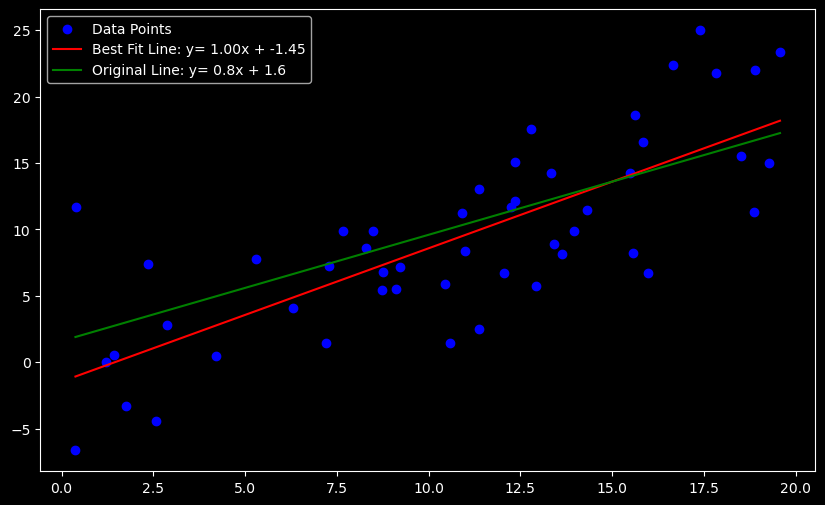

In [ ]:
# Use sklearn's LinearRegression to get the best-fit line for our dataset df

from sklearn.linear_model import LinearRegression

# Create a LinearRegression object
linreg = LinearRegression() 

# Fit the model to our data
linreg.fit(df[['X']], df['Y'])

# Get the slope and intercept
m = linreg.coef_[0]
b = linreg.intercept_

# Calculate the residuals of the predicted values of the fitted model
resisduals_pred = df['Y'] - (m*df['X'] + b)

# Compute original MSE and MSE of the fitted model
mse_original = np.mean(residuals**2)
mse_fitted = np.mean(resisduals_pred**2)

# Display the MSE values
print(f'MSE of Original Model: {mse_original:.2f}')
print(f'MSE of Fitted Model: {mse_fitted:.2f}')

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# add scatterplot of our data
plt.scatter(df['X'], df['Y'], color='blue', label='Data Points')

# add the best fit line y = mx + b
plt.plot(df['X'], m*df['X'] + b, color='red', label= f'Best Fit Line: y= {m:.2f}x + {b:.2f}')

# add the original line y = 0.8x + 1.6
plt.plot(df['X'], 0.8*df['X'] + 1.6, color='green', label='Original Line: y= 0.8x + 1.6')

# add the legend
plt.legend()
plt.show()


Not bad. Now, let's also compute the parameters $\hat{b}$ and $\hat{w}$ by hand in two ways:

- By inverting the matrix in the normal equations
- By applying the formulas for $\hat{b}$ and $\hat{w}$

Then, we compare these with the results obtained from `sklearn`.

In [36]:
# Compute m and b using formulas
m_formula = ((x - np.mean(x)) @ (y - np.mean(y))) / ((x - np.mean(x)) @ (x - np.mean(x)))
b_formula = np.mean(y) - m_formula * np.mean(x)

# Compute m and b using normal equations

# Create augmented design matrix
X = np.c_[np.ones(len(x)), x]

# Create X^TX matrix
XTX = X.T @ X

# Create X^TX inverse matrix
XTX_inv = np.linalg.inv(XTX)

# Create X^Ty matrix
XTy = X.T @ y

# Compute m and b using normal equations
b_normal, m_normal = XTX_inv @ XTy

# Make dataframe with columns m and b, rows corresponding to three methods
coeffs_df = pd.DataFrame({"Method": ['sklearn', 'formula', 'normal eq'],
                          "slope" : [m, m_formula, m_normal],
                            "intercept" : [b, b_formula, b_normal]})

coeffs_df

,Method,slope,intercept
0,sklearn,1.003528,-1.452361
1,formula,1.003528,-1.452361
2,normal eq,1.003528,-1.452361
